# Problem understanding

### Renting an apartment is always a difficult and stressing process that often seems impulsive or risky. If the renting itself is already hard, doing it in Prague doesn’t make it any easier. With increasing city regulations, growing tourism and population, renting an apartment in Prague leaves many desperate for the first opportunity available, becoming vulnerable to scams and overpriced contracts.

### In this project, I will go through a process of gathering the data, data cleaning, data exploration, feature engineering and finally applying a machine learning model that predicts rental prices of city’s apartments based on chosen features. At the end, I will visualize the apartments price change over some period of time, which could help to understand the market trends.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import folium

# Data collection

### Data was scraped from bezrealitky.cz website and saved into .csv file. Here the data is loaded into DataFrame.

In [2]:
df = pd.read_csv(os.getcwd()+'\\Praha_Apartment_Scraped_Data\\Prague-Bezrealitky-2021-06-17.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   listing_id     2605 non-null   int64  
 1   layout         2605 non-null   object 
 2   condition      1947 non-null   object 
 3   floor_area     2593 non-null   float64
 4   price          2605 non-null   int64  
 5   fees           2571 non-null   float64
 6   deposit        2226 non-null   float64
 7   district       2605 non-null   object 
 8   building_type  2396 non-null   object 
 9   penb           1911 non-null   object 
 10  furnishing     2501 non-null   object 
 11  floor          2493 non-null   float64
 12  balcony        2605 non-null   object 
 13  terrace        2605 non-null   object 
 14  cellar         2605 non-null   object 
 15  loggia         2605 non-null   object 
 16  parking        2605 non-null   object 
 17  elevator       2605 non-null   object 
 18  garage  

In [4]:
df.head()

,listing_id,layout,condition,floor_area,price,fees,deposit,district,building_type,penb,...,terrace,cellar,loggia,parking,elevator,garage,heating,age,latitude,longitude
0,505662,2 bedroom,NaN,50.0,12500,3374.0,12000.0,Vokovice,Prefab concrete building,NaN,...,No,Yes,No,No,Yes,No,District heating,NaN,50.099086,14.361687
1,668984,2 bedroom,Good,53.0,12600,3400.0,16000.0,Malešice,Prefab concrete building,G,...,No,No,No,No,No,No,NaN,NaN,50.083270,14.504400
2,535672,3 bedroom,NaN,90.0,20000,5500.0,30000.0,Stodůlky,Prefab concrete building,NaN,...,No,Yes,No,Yes,No,No,District heating,NaN,50.051998,14.313023
3,436910,2 bedroom with open-plan kitchen,NaN,63.0,20000,3500.0,40000.0,Košíře,Brick building,NaN,...,No,Yes,No,No,No,No,Gas boiler,1 to 10 years,50.065055,14.360426
4,664569,1 bedroom with open-plan kitchen,Excellent,50.0,13000,4000.0,17000.0,Horní Počernice,Brick building,G,...,No,Yes,No,No,No,No,District heating,NaN,50.113210,14.616900


# Data cleaning

### At the very beginning I am dropping the outliers and values that that are unreal.

In [5]:
df = df[df['floor_area']>10]
df = df[df['floor_area']<125]

In [6]:
df = df[df['price']>3000]
df = df[df['price']<30000]

### I am plotting the pairplots to have a quick overview and relation between data.

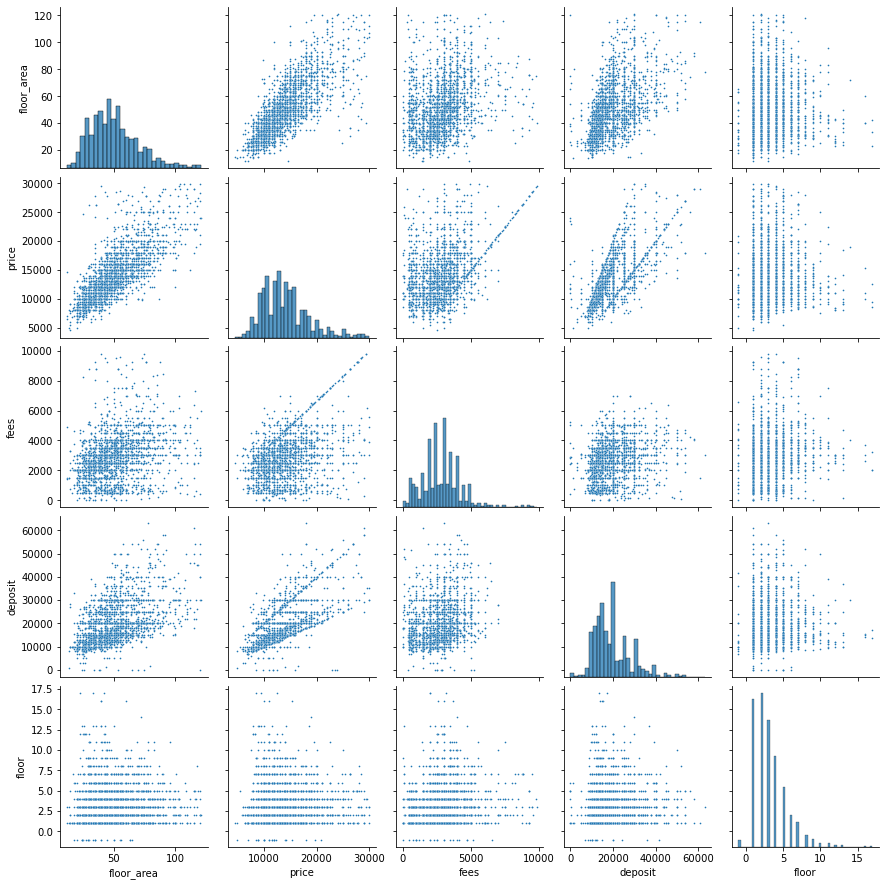

In [7]:
sns.pairplot(data=df.drop(['listing_id','latitude','longitude'],axis=1),plot_kws={"s":3});

### It is possible to notice strange linear relation between price and the fees of the apartment. I will explore it more closely:

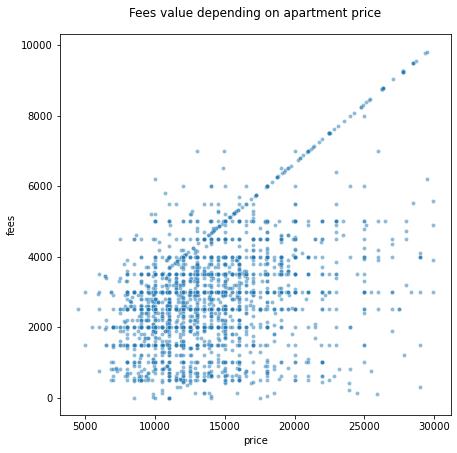

In [8]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=df['price'],y=df['fees'],s=16,alpha=0.5);
plt.title('Fees value depending on apartment price',y=1.03);

### It seems that the apartment listing portal is puting the fees values equal 1/3 of the apartment price in case the user did not specified it. I am going to replace such fees with the NaN value:

In [9]:
df['ratio'] = df['price']/df['fees']
df.loc[(df['ratio'].between(2.95,3.05)) & (df['price']>10000),'fees'] = np.nan
df = df.drop('ratio',axis=1)

### I am going to fill the NaN values of the fee using other feature. I am going to check the correlation of the exising fee values to the other features to help me decide which feature to use:

In [10]:
df.corr()['fees'].sort_values()

latitude     -0.000630
longitude     0.030688
listing_id    0.044250
floor         0.136938
deposit       0.243212
price         0.289280
floor_area    0.365903
fees          1.000000
Name: fees, dtype: float64

### The floor area of the apartment is most correlated to the fees. I am going to use that feature to fill the missing fee values with polynomial regression.

In [11]:
fees_df = df[['floor_area','fees']]
fees_df = fees_df.dropna()
fees_coeff = np.polyfit(fees_df['floor_area'],fees_df['fees'],1)
df['fees'] = df['fees'].fillna(fees_coeff[0]*df['floor_area'] + fees_coeff[1])

### I am going to drop the low and unrealisitic fee values that are below 500 CZK:

In [12]:
df = df[df['fees']>500]

### The price and fees relation is now presenting accordingly:

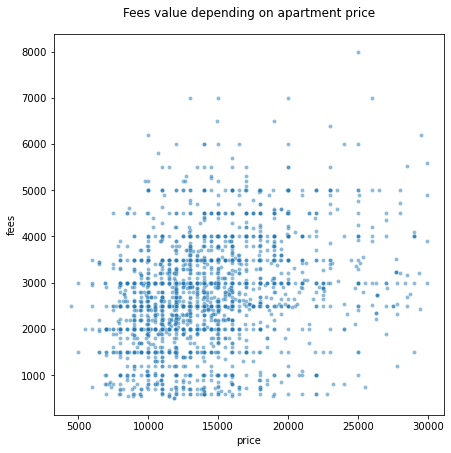

In [13]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=df['price'],y=df['fees'],s=16,alpha=0.5);
plt.title('Fees value depending on apartment price',y=1.03);

### There are linear relations between deposit and price of the aparment but it makes sense since often the deposit is equal the price or double the price of the apartmente. It is also possible to see some flat values of deposit around rounded values of numbers.

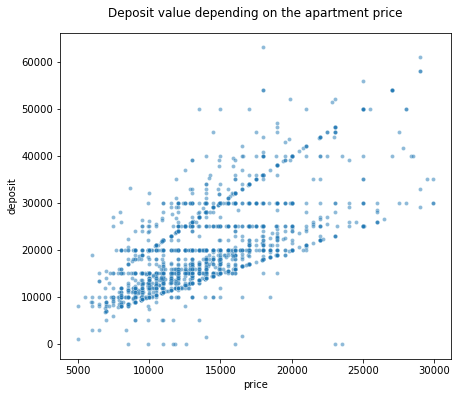

In [14]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=df['price'],y=df['deposit'],s=16,alpha=0.5);
plt.title('Deposit value depending on the apartment price',y=1.03);

### Tenants usually care about total cost of the apartments, not paying attention how much of it contributes to the rent and how much to the fees. Therefore I am creating a new column that contains the total price of the apartment: 

In [15]:
df['total_price']=df['price']+df['fees']

# Data exploration

### I am going to plot at the map where are the listed apartments:

In [16]:
map_praha = folium.Map(location=[50.0754, 14.4280], zoom_start=12,tiles = "Stamen Toner")

for lat, lng in zip(df['latitude'],df['longitude']):
    folium.CircleMarker([lat, lng],radius=1,color='red').add_to(map_praha)  
    
map_praha

### I am going to check the avarage fee and deposit of the apartments in Prague:

In [17]:
fees_mean = df['fees'].mean()
print(f'Average fees for listed apartments are: {round(fees_mean)} CZK.')

Average fees for listed apartments are: 2755 CZK.


In [18]:
deposit_ratio = df['deposit']/df['price']
deposit_ratio_mean = round(deposit_ratio.mean(),1)
print(f'Average deposit value is {deposit_ratio_mean} of the apartment rent price.')

Average deposit value is 1.4 of the apartment rent price.


### There is clear relation between price and area of the apartment:

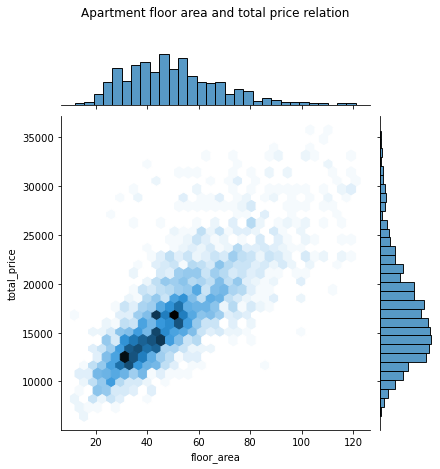

In [19]:
sns.jointplot(data=df,x='floor_area',y='total_price',kind='hex')
plt.title('Apartment floor area and total price relation',y=1.3);

### I am going to plot the avarage apartment price for the 30 disctricts that have the most of the listings:

In [20]:
top_disctricts = df['district'].value_counts()[:30]
df_top_disctricts = df[df['district'].isin(top_disctricts.index)]
sorted_top_districts = df_top_disctricts.groupby('district').mean()['total_price'].reset_index().sort_values('total_price',ascending=False)['district']

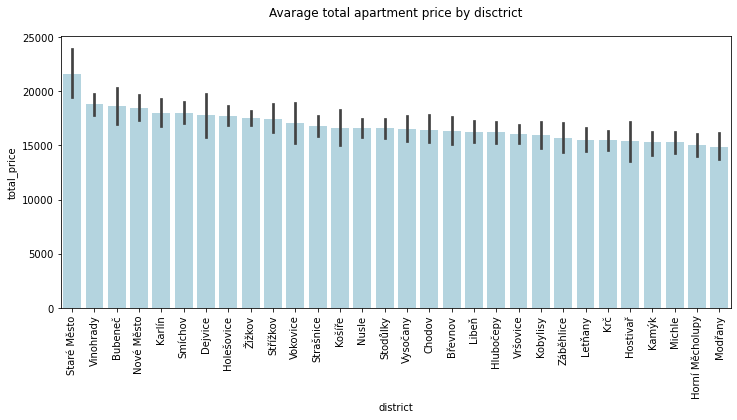

In [21]:
plt.figure(figsize=(12,5))
sns.barplot(data=df_top_disctricts,x='district',y='total_price',color='lightblue',order=sorted_top_districts)
plt.xticks(rotation=90);
plt.title('Avarage total apartment price by disctrict',y=1.05);

### Stare Mesto is the most expensive district to rent a flat. Since it is historic centre of the Prague, it was an expected result.

### I am going to plot the number of available listings depending on the type apartment layout and check its relation to the renting price:

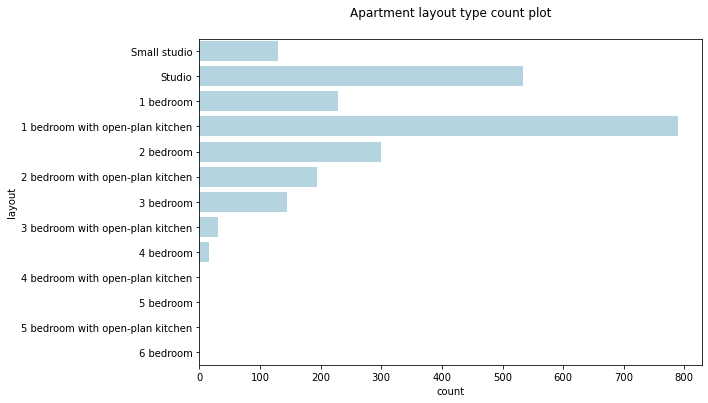

In [22]:
layout_order = ['Small studio','Studio','1 bedroom','1 bedroom with open-plan kitchen','2 bedroom','2 bedroom with open-plan kitchen','3 bedroom','3 bedroom with open-plan kitchen','4 bedroom','4 bedroom with open-plan kitchen','5 bedroom','5 bedroom with open-plan kitchen','6 bedroom']
plt.figure(figsize=(9,6))
sns.countplot(data=df,y='layout',color='lightblue',order=layout_order);
plt.title('Apartment layout type count plot',y=1.05);

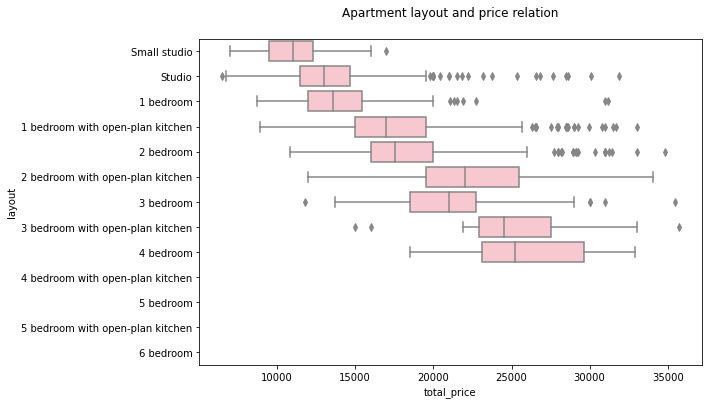

In [23]:
plt.figure(figsize=(9,6))
sns.boxplot(data=df,x='total_price',y='layout',order=layout_order,color='pink')
plt.title('Apartment layout and price relation',y=1.05);

### The most popular are apartments with 1 room with a kitchen. The higher the number of the rooms in the apartment the higher the prices are.

### I am going to plot the number of available listings depending on the condition of the apartment:

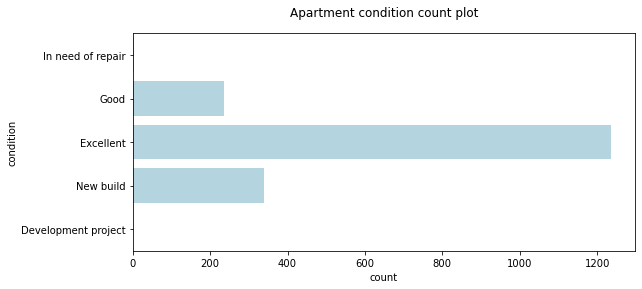

In [24]:
condition_order = ['In need of repair','Good','Excellent','New build','Development project']
plt.figure(figsize=(9,4))
sns.countplot(data=df,y='condition',order=condition_order,color='lightblue');
plt.title('Apartment condition count plot',y=1.05);

### Most of the apratment are said to be in Excellent condition.

### I am going to plot the number of available listings depending on the furnishment and check its relation to the renting price:

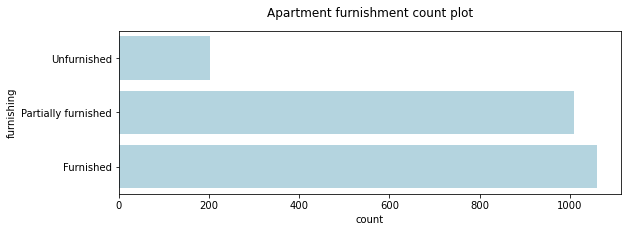

In [25]:
plt.figure(figsize=(9,3))
furnishing_order = ['Unfurnished','Partially furnished','Furnished']
sns.countplot(data=df,y='furnishing',color='lightblue',order=furnishing_order);
plt.title('Apartment furnishment count plot',y=1.05);

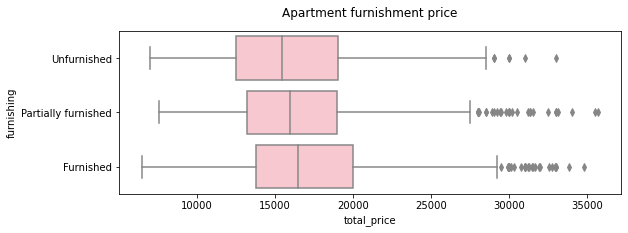

In [26]:
plt.figure(figsize=(9,3))
sns.boxplot(data=df,x='total_price',y='furnishing',order=furnishing_order,color='pink')
plt.title('Apartment furnishment price',y=1.05);

### The unfurnished apartments are minority. This is also reflected by the price.

### I am also going to plot the number of available apartment depending on: buliding type, heating type, parking availability and floor number.

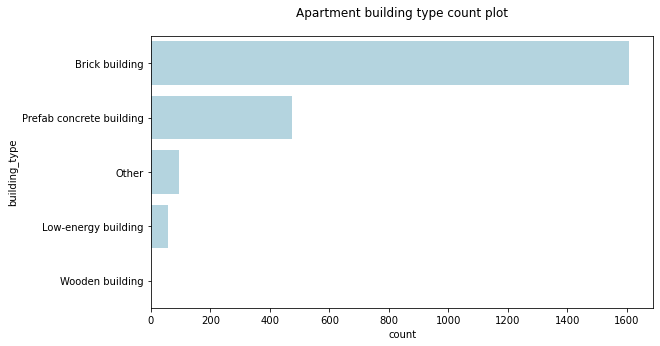

In [27]:
plt.figure(figsize=(9,5))
sns.countplot(data=df,y='building_type',order=df['building_type'].value_counts().index,color='lightblue');
plt.title('Apartment building type count plot',y=1.05);

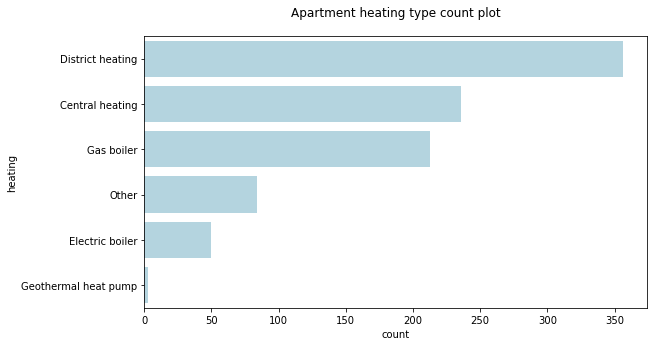

In [28]:
plt.figure(figsize=(9,5))
sns.countplot(data=df,y='heating',color='lightblue',order=df['heating'].value_counts().index)
plt.title('Apartment heating type count plot',y=1.05);

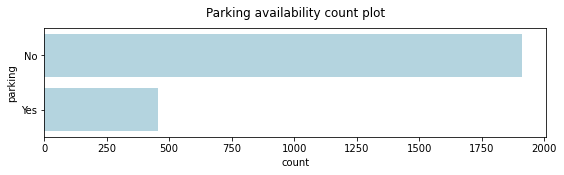

In [29]:
plt.figure(figsize=(9,2))
sns.countplot(data=df,y='parking',color='lightblue')
plt.title('Parking availability count plot',y=1.05);

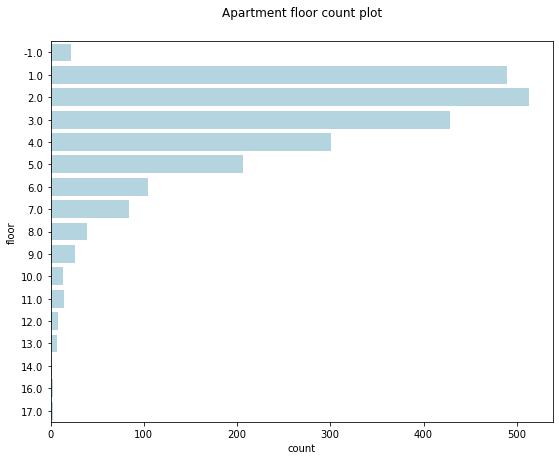

In [30]:
plt.figure(figsize=(9,7))
sns.countplot(data=df,y='floor',color='lightblue')
plt.title('Apartment floor count plot',y=1.05);

# Feature Engineering

### I am changing the categorical features into the ordinal numeric values:

In [31]:
df['layout'] = df['layout'].map({
                                    'Small studio':0.5, 
                                    'Studio':0.75,
                                    '1 bedroom with open-plan kitchen':1.5,
                                    '1 bedroom':1,
                                    '2 bedroom with open-plan kitchen':2.5,
                                    '2 bedroom':2,
                                    '3 bedroom with open-plan kitchen':3.5,
                                    '3 bedroom':3,
                                    '4 bedroom with open-plan kitchen':4.5,
                                    '4 bedroom':4,
                                    '5 bedroom with open-plan kitchen':5.5,   
                                    '5 bedroom':5,
                                    '6 bedroom':6.5,
                                                                                })

In [32]:
df['condition'] = df['condition'].map({
                                            'Good':1, 
                                            'Excellent':2,
                                            'New build':3,
                                                            })

In [33]:
df['penb'] = df['penb'].map({
                                'G':7,
                                'F':6,
                                'E':5, 
                                'D':4,
                                'C':3,
                                'B':2, 
                                'A':1,
                                        })

In [34]:
df['furnishing'] = df['furnishing'].map({
                                            'Unfurnished':1,
                                            'Partially furnished':2,
                                            'Furnished':3, 
                                                                        })

In [35]:
df['age'] = df['age'].map({
                            '1 to 10 years':1,
                            '10 to 30 years':2,
                            '30 to 50 years':3,
                            'over 50 years':4
                                                })

### The yes/no values are mapped with 1 and 0: 

In [36]:
df['balcony'] = df['balcony'].map({'Yes':1,'No':0})
df['terrace'] = df['terrace'].map({'Yes':1,'No':0})
df['cellar'] = df['cellar'].map({'Yes':1,'No':0})
df['loggia'] = df['loggia'].map({'Yes':1,'No':0})
df['parking'] = df['parking'].map({'Yes':1,'No':0})
df['elevator'] = df['elevator'].map({'Yes':1,'No':0})
df['garage'] = df['garage'].map({'Yes':1,'No':0})

### I am going to plot correlation of the total apartment price to the available features. This will help me to choose which of them to keep or remove in case of missing data.

In [37]:
corr_data = df.corr()['total_price'].sort_values()[:-1]
corr_data = corr_data.drop('deposit',axis=0)
corr_data = corr_data.drop('price',axis=0)
corr_data = corr_data.drop('fees',axis=0)

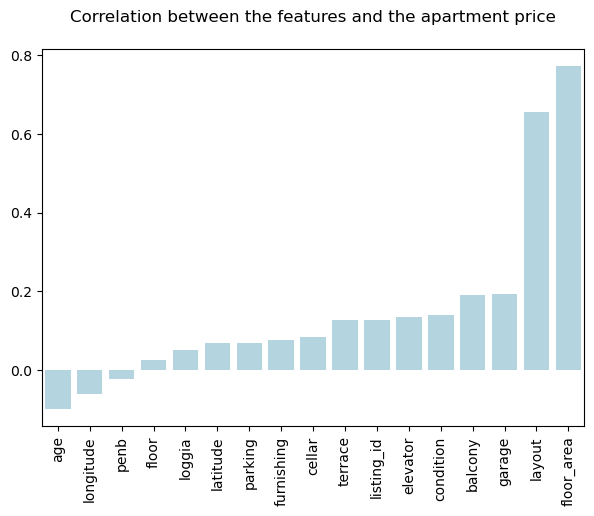

In [38]:
plt.figure(figsize=(7,5), dpi=100)
sns.barplot(x=corr_data.index,y=corr_data.values,color='lightblue');
plt.xticks(rotation=90)
plt.title('Correlation between the features and the apartment price',y=1.05);

### I am checking how many percent of data is missing for each feature.

In [39]:
100*df.isnull().sum()/len(df)

listing_id        0.000000
layout            0.168776
condition        23.586498
floor_area        0.000000
price             0.000000
fees              0.000000
deposit          12.489451
district          0.000000
building_type     5.780591
penb             24.936709
furnishing        4.092827
floor             4.514768
balcony           0.000000
terrace           0.000000
cellar            0.000000
loggia            0.000000
parking           0.000000
elevator          0.000000
garage            0.000000
heating          60.253165
age              78.565401
latitude          0.000000
longitude         0.000000
total_price       0.000000
dtype: float64

### I am droping the columns that has lot of missing data or features that will be not much useful for the Machine Learning model. I am also dropping price and fees columns because I am going to use total price as a label for the Machine Learning model.

In [40]:
df = df.drop('listing_id',axis=1)
df = df.drop('heating',axis=1)
df = df.drop('age',axis=1)
df = df.drop('deposit',axis=1)
df = df.drop('price',axis=1)
df = df.drop('fees',axis=1)
df = df.drop('penb',axis=1)

### I am dropping the rows that contain very rare values that will be not helpful for the model.

In [41]:
df = df[df['condition']!='In need of repair']
df = df[df['condition']!='Development project']
df = df[df['layout']!='Other']
df = df[df['building_type']!='Wooden building']

### I am dropping all the remaining rows with missing data except for the the condition.

In [42]:
df = df.dropna(axis=0,subset=['layout','building_type','furnishing','floor'])

In [43]:
100*df.isnull().sum()/len(df)

layout            0.000000
condition        19.635827
floor_area        0.000000
district          0.000000
building_type     0.000000
furnishing        0.000000
floor             0.000000
balcony           0.000000
terrace           0.000000
cellar            0.000000
loggia            0.000000
parking           0.000000
elevator          0.000000
garage            0.000000
latitude          0.000000
longitude         0.000000
total_price       0.000000
dtype: float64

### Almost 20% of the data has the missing value for the condition feature. Since it is rather important feature I decide to keep it and drop all the rows with missing data of that feature.

In [44]:
df = df.dropna()

### I am going to rename the districts that have little amount of apartment listed to 'other'.

In [45]:
top_40_districts = df['district'].value_counts()[:40].index

In [46]:
def rare(district):
    if district not in top_40_districts:
        return 'Other'
    else:
        return district

In [47]:
df['district'] = df['district'].apply(rare)

### I am splitting the data into label and features.

In [48]:
y = df['total_price']
X = df.drop('total_price',axis=1)

### I am performing one-hote encoding for categorical data.

In [49]:
X_zero = pd.get_dummies(X,drop_first=True)

### I am spliting the data into train and test sets.

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_zero,y,test_size=0.15,random_state=101)

# Modeling

### Fitting and tuning the Grading Tree Boosting model.

In [51]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV

# gbr_model = GradientBoostingRegressor()
# param_grid = {'n_estimators':[50,150,250],
#               'max_depth':[1,2,3,4],
#               'learning_rate':[0.02,0.04,0.06,0.08],
#               'subsample':[0.2,0.4,0.6,0.8],
#               'min_samples_split':[2,3,4,5],
#               'min_samples_leaf':[1,2,3,4,5],
#               'max_features':['auto','sqrt']}            
# grid_model = GridSearchCV(gbr_model,param_grid,scoring='neg_mean_absolute_error',cv=16,verbose=2,n_jobs=-1)

### The model fit is repeated for best parameters found earlier via GridSearchCV.

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
grid_model = GradientBoostingRegressor(learning_rate=0.06, max_depth=3, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=250, subsample=0.6,random_state=0)
grid_model.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.06, max_features='auto',
                          min_samples_leaf=3, min_samples_split=4,
                          n_estimators=250, random_state=0, subsample=0.6)

# Model evaluation

In [53]:
y_pred = grid_model.predict(X_test)
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_test,y_pred)
ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
print(f'Mean error: {np.round(MAE)} CZK')
print(f'Mean error: {np.round(ERR)} %')

Mean error: 1892.0 CZK
Mean error: 11.0 %


### I am goint to plot the importance of each feature in the model for the price prediction.

In [54]:
feat_import = grid_model.feature_importances_
imp_feats = pd.DataFrame(index=X_zero.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.004]
imp_feats = imp_feats.sort_values("Importance",ascending=False)

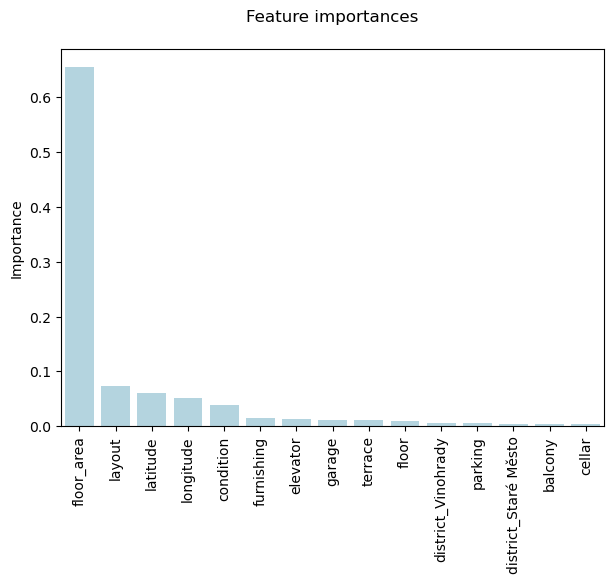

In [55]:
plt.figure(figsize=(7,5),dpi=100)
sns.barplot(data=imp_feats,x=imp_feats.index,y='Importance',color='lightblue');
plt.title('Feature importances',y=1.05);
plt.xticks(rotation=90);

# Market trend analysis

### I am going to create pipeline that trains the model on the new input data and return the prices for the set of apartment features that were collected at the beginning.

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

def predict(df):

    df = df[df['floor_area']>10]
    df = df[df['floor_area']<125]
    df = df[df['price']>3000]
    df = df[df['price']<30000]
    df['ratio'] = df['price']/df['fees']
    df.loc[(df['ratio'].between(2.95,3.05)) & (df['price']>10000),'fees'] = np.nan
    df = df.drop('ratio',axis=1)
    fees_df = df[['floor_area','fees']]
    fees_df = fees_df.dropna()
    fees_coeff = np.polyfit(fees_df['floor_area'],fees_df['fees'],1)
    df['fees'] = df['fees'].fillna(fees_coeff[0]*df['floor_area'] + fees_coeff[1])
    df = df[df['fees']>500]
    df['total_price']=df['price']+df['fees']
    
    df['layout'] = df['layout'].map({
                                        'Small studio':0.5, 
                                        'Studio':0.75,
                                        '1 bedroom with open-plan kitchen':1.5,
                                        '1 bedroom':1,
                                        '2 bedroom with open-plan kitchen':2.5,
                                        '2 bedroom':2,
                                        '3 bedroom with open-plan kitchen':3.5,
                                        '3 bedroom':3,
                                        '4 bedroom with open-plan kitchen':4.5,
                                        '4 bedroom':4,
                                        '5 bedroom with open-plan kitchen':5.5,   
                                        '5 bedroom':5.5,
                                        '6 bedroom':6.5,
                                                                                    })

    df['condition'] = df['condition'].map({
                                                'Good':1, 
                                                'Excellent':2,
                                                'New build':3,
                                                                })

    df['furnishing'] = df['furnishing'].map({
                                                'Unfurnished':1,
                                                'Partially furnished':2,
                                                'Furnished':3, 
                                                                            })

    df['balcony'] = df['balcony'].map({'Yes':1,'No':0})
    df['terrace'] = df['terrace'].map({'Yes':1,'No':0})
    df['cellar'] = df['cellar'].map({'Yes':1,'No':0})
    df['loggia'] = df['loggia'].map({'Yes':1,'No':0})
    df['parking'] = df['parking'].map({'Yes':1,'No':0})
    df['elevator'] = df['elevator'].map({'Yes':1,'No':0})
    df['garage'] = df['garage'].map({'Yes':1,'No':0})

    df = df.drop('listing_id',axis=1)
    df = df.drop('heating',axis=1)
    df = df.drop('age',axis=1)
    df = df.drop('deposit',axis=1)
    df = df.drop('price',axis=1)
    df = df.drop('fees',axis=1)
    df = df.drop('penb',axis=1)

    df = df[df['condition']!='In need of repair']
    df = df[df['condition']!='Development project']
    df = df[df['layout']!='Other']
    df = df[df['building_type']!='Wooden building']
    
    df = df.dropna()

    df['district'] = df['district'].apply(rare)

    y = df['total_price']
    X = df.drop('total_price',axis=1)

    X = pd.get_dummies(X,drop_first=True)
    
    gbr_model2 = GradientBoostingRegressor(learning_rate=0.06, max_depth=3, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=250, subsample=0.6,random_state=0)
    gbr_model2.fit(X,y)
    y_pred_new = gbr_model2.predict(X_zero)
    
    return y_pred_new

### I am going to predict prices of same apartments based on the data collected during different periods of time. Then I will calculate the percentage change of the prices from the initial date and plot it.

In [57]:
files = os.listdir('Praha_Apartment_Scraped_Data')
df_trend = pd.DataFrame(columns=['Date','Percentage change'])

df_zero = pd.read_csv(os.getcwd()+'\\Praha_Apartment_Scraped_Data\\Prague-Bezrealitky-2021-06-17.csv')
y_zero = predict(df_zero)

for file in files:
    print(f'Processing {file}')
    path = os.getcwd()+'\\Praha_Apartment_Scraped_Data\\'+file
    date_object = datetime.strptime(file, 'Prague-Bezrealitky-%Y-%m-%d.csv')
    df_ = pd.read_csv(path)
    y_new = predict(df_)
    delta = (y_new - y_zero)/y_zero
    y_change = delta.mean()*100
    
    df_trend = df_trend.append({'Date':date_object,'Percentage change':y_change},ignore_index=True)

Processing Prague-Bezrealitky-2021-06-17.csv
Processing Prague-Bezrealitky-2021-06-25.csv
Processing Prague-Bezrealitky-2021-07-05.csv
Processing Prague-Bezrealitky-2021-07-13.csv
Processing Prague-Bezrealitky-2021-07-21.csv
Processing Prague-Bezrealitky-2021-07-29.csv
Processing Prague-Bezrealitky-2021-08-06.csv
Processing Prague-Bezrealitky-2021-08-12.csv
Processing Prague-Bezrealitky-2021-08-20.csv
Processing Prague-Bezrealitky-2021-08-28.csv
Processing Prague-Bezrealitky-2021-09-03.csv
Processing Prague-Bezrealitky-2021-09-09.csv
Processing Prague-Bezrealitky-2021-09-15.csv


### Over the analized period of time, the rental prices in Prague rose over +4%

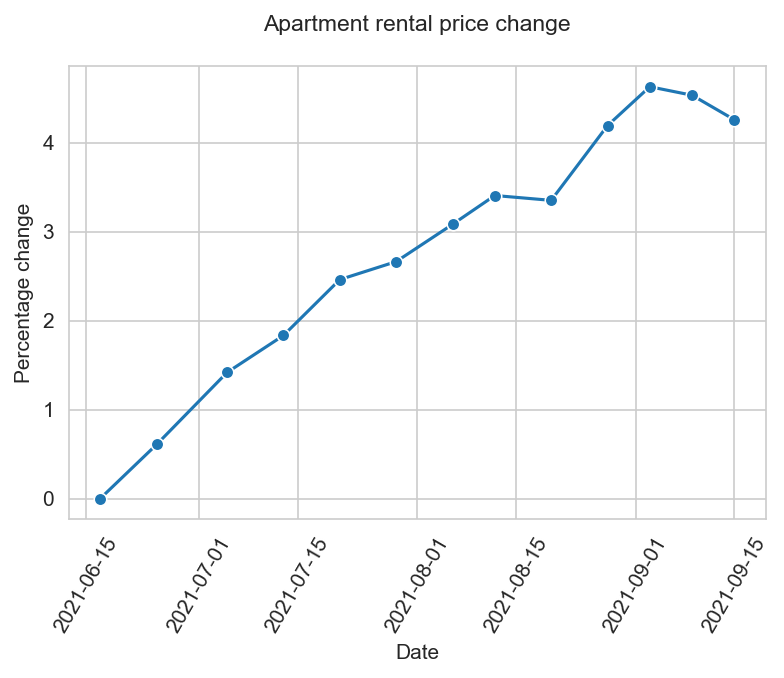

In [60]:
sns.set_style("whitegrid")
plt.figure(dpi=150)
sns.lineplot(data=df_trend,x='Date',y='Percentage change',marker='o')
plt.xlabel("Date", fontsize= 10)
plt.ylabel("Percentage change", fontsize= 10)
plt.title("Apartment rental price change", fontsize= 11, y=1.05)
plt.xticks(rotation=60);

### Thank you.